In [24]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [25]:
#torch.cuda.set_device(0)
# specify dtype
use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(torch.cuda.device_count())
print(use_cuda)

1
True


In [39]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-5
momentum = 0.9
num_epoch = 10
show_every = 2000

In [40]:
class Flatten(nn.Module):
    def forward(self, x):
        # read in N, C, H, W
        N, C, H, W = x.size()
        # flatten the C * H * W values into a single vector per image
        return x.view(N, -1)  
    
class idp_tensor(nn.Module):
    def __init__(self, idp):
        super(idp_tensor, self).__init__()
        self.idp = idp
    def forward(self, c):
        #c is an input tensor, size N*C*H*W
        N, C, H, W = c.size()
        non_zero_channel = int(C*(self.idp))
        if C-non_zero_channel > 0:
            zeros = Variable(torch.zeros(N, C-non_zero_channel, H, W)).type(dtype)
            c = torch.cat([c[:, :non_zero_channel, :, :].clone(), zeros], 1).type(dtype)
            #c[:, non_zero_channel:, :, :] = zeros
            return c
        else:
            return c
        
class func_allone(nn.Module):
    def forward(self, x):
        #x is an input tensor, size N*C*H*W
        #for cnn, functions are applied to each filter
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), Variable(torch.ones(N, C, H, W), requires_grad=False).type(dtype))
        return x

class func_linear(nn.Module):
    def __init__(self, k=1):
        super(func_linear, self).__init__()
        self.k = k
    def channel_coeff(self, N, C, H, W):
        #C is channels, return a list with corresponding index: [k, k/2,...]
        #returns a tensor with size N*C*H*W
        coeff = list(map(lambda a: 1-(a/(C+1)), range(0,C)))
        tensor_list = []
        for c in coeff:
            coeff_tensor = torch.ones(H, W)
            coeff_tensor = torch.mul(coeff_tensor, c)
            tensor_list.append(coeff_tensor)
        ct = torch.stack(tensor_list, 0)
        ct = torch.stack(([ct]*N))
        return ct
    
    def forward(self, x):
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), Variable(self.channel_coeff(N, C, H, W), requires_grad=False).type(dtype))
        return x
        
class func_harmonic(nn.Module):
    #perform element-wise multiplication to channels in x with coefficient k/n, n is channel index
    def __init__(self, k=1):
        super(func_harmonic, self).__init__()
        self.k = k
    def channel_coeff(self, N, C, H, W):
        #C is channels, return a list with corresponding index: [k, k/2,...]
        #returns a tensor with size N*C*H*W
        coeff = list(map(lambda a: self.k/a, range(1,C+1)))
        tensor_list = []
        for c in coeff:
            coeff_tensor = torch.ones(H, W)
            coeff_tensor = torch.mul(coeff_tensor, c)
            tensor_list.append(coeff_tensor)
        ct = torch.stack(tensor_list, 0)
        ct = torch.stack(([ct]*N))
        return ct
    
    def forward(self, x):
        #x is an input tensor, size N*C*H*W
        #for cnn, functions are applied to each filter
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), Variable(self.channel_coeff(N, C, H, W), requires_grad=False).type(dtype))
        return x

In [41]:
class coef_idp_VGG(nn.Module):
    def __init__(self, idp, idp_layers):
        #idp is 0~1, idp_layers is a set, specify which layer in features should apply idp
        #now idp_layers is 1,3,6,8,11,13,15,18,20,22,25,27,29
        super(coef_idp_VGG, self).__init__()
        self.idp = idp
        self.idp_layers = idp_layers
        self.features = nn.Sequential(*(self.new_features_list()))
        self.classifier = nn.Sequential(nn.Linear(512, 512),
                              nn.ReLU(inplace=True),
                              nn.Dropout(0.5),
                              nn.Linear(512, 10))
    
    def new_features_list(self):
        new_layers = []
        for i, layer in enumerate(list(models.vgg16(pretrained=True).type(dtype).features.children())):
            if i not in self.idp_layers:
                new_layers.append(layer)
            else:
                new_layers.append(layer)
                new_layers.append(func_linear())
                new_layers.append(idp_tensor(self.idp))
        new_layers.append(Flatten())
        return new_layers        
    
    def forward(self, x):
        out = self.features(x)
        out = self.classifier(out)
        return out

In [42]:
# Data
print('==> Preparing data..')
data_path = '/data/put_data/frank840925/IDP/data'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = torchvision.datasets.CIFAR10(root=data_path, 
                                        train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=data_path, 
                                       train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

print(trainset.__len__())
print(testset.__len__())

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [43]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_losses(loss_history1=None, loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue", label="train")
    if loss_history2:
        ax1.plot(loss_history2, color="green", label="test")
    #ax2 = ax1.twinx()
    #ax2.set_yscale('log')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Cross-entropy loss")
    plt.savefig('output_losses.png')

def plot_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(111)
    if accuracy1:
        ax1.plot(accuracy1, color="red", label="train")
    if accuracy2:
        ax1.plot(accuracy2, color="black", label="test")
    plt.xlabel("epoch") 
    plt.ylabel("accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Train/Test accuracy") 
    plt.savefig('accuracy.png')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([32, 3, 32, 32])


In [44]:
#net = VGG16(idp=1).type(dtype)
idp = 1
idp_layers = {1,3,6,8,11,13,15,18,20,22,25,27,29}
net = coef_idp_VGG(1,idp_layers).type(dtype)

x = Variable(torch.randn(32, 3, 32, 32)).type(dtype)
out = net(x)
print(out.size())

torch.Size([32, 10])


In [45]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD([{'params': net.features.parameters()},
#                       {'params': net.classifier.parameters(), 'lr': 1e-3}], lr=3e-4, momentum=momentum)
optimizer = optim.SGD(net.parameters(), lr=4e-3, momentum=momentum)

In [46]:
#for i, param in enumerate(net.parameters()):
#    print(i, param.size())

In [47]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

# start training
for epoch in range(num_epoch):  # loop over the dataset multiple times
    running_loss1 = []
    running_loss2 = []
    running_correct1=[]
    running_correct2=[]
    for i, data in enumerate(trainloader, 0):
        correct = 0
        net.train(True)
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        inputs, labels = Variable(inputs).type(dtype), Variable(labels).type(torch.cuda.LongTensor)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        # loss
        running_loss1.append(loss.data[0])
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        correct = correct/labels.size(0)*100
        running_correct1.append(correct)
        
    for i, tdata in enumerate(testloader, 0):
        test_correct = 0
        net.train(False)
        tinputs, tlabels = tdata
        tinputs, tlabels = Variable(tinputs).type(dtype), Variable(tlabels).type(torch.cuda.LongTensor)
        toutput = net(tinputs)
        tloss = criterion(toutput, tlabels)
        running_loss2.append(tloss.data[0])
        _, tpredicted = torch.max(toutput.data, 1)
        test_correct += (tpredicted == tlabels.data).sum()
        test_correct = test_correct/tlabels.size(0)*100
        running_correct2.append(test_correct)
    
    train_loss.append(np.mean(running_loss1))
    test_loss.append(np.mean(running_loss2))
    train_acc.append(np.mean(running_correct1))
    test_acc.append(np.mean(running_correct2))
    
    #statistics
    print('Epoch [%d/%d], Loss: %.4f, Train Accuracy: %r percent' 
                %(epoch+1, num_epoch, train_loss[-1], train_acc[-1]))

print('Finished Training')

Epoch [1/10], Loss: 2.0432, Train Accuracy: 19.139875239923224 percent
Epoch [2/10], Loss: 1.1138, Train Accuracy: 57.70353486884197 percent
Epoch [3/10], Loss: 0.7140, Train Accuracy: 75.563819577735131 percent
Epoch [4/10], Loss: 0.5376, Train Accuracy: 82.033749200255912 percent
Epoch [5/10], Loss: 0.4299, Train Accuracy: 85.904510556621887 percent
Epoch [6/10], Loss: 0.3424, Train Accuracy: 88.947536788227765 percent
Epoch [7/10], Loss: 0.2878, Train Accuracy: 90.493042226487518 percent
Epoch [8/10], Loss: 0.2418, Train Accuracy: 91.994561740243128 percent
Epoch [9/10], Loss: 0.1963, Train Accuracy: 93.472088931541904 percent
Epoch [10/10], Loss: 0.1658, Train Accuracy: 94.531749840051177 percent
Finished Training


In [48]:
# Save the Model
torch.save(net.state_dict(), 'linear_idp_model.pkl')

In [49]:
net

coef_idp_VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): func_linear (
    )
    (3): idp_tensor (
    )
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU (inplace)
    (6): func_linear (
    )
    (7): idp_tensor (
    )
    (8): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU (inplace)
    (11): func_linear (
    )
    (12): idp_tensor (
    )
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU (inplace)
    (15): func_linear (
    )
    (16): idp_tensor (
    )
    (17): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (18): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (19): ReLU (inplace)
    (20): func_linear (
    )
    (21): idp_tensor (
    )
    (22): Conv2d(256, 256, kerne

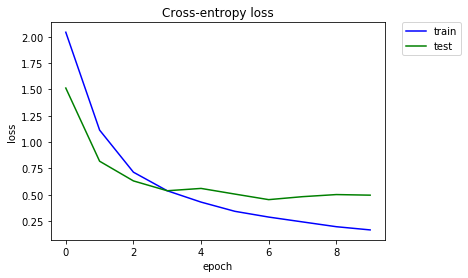

In [50]:
plot_losses(train_loss, test_loss)

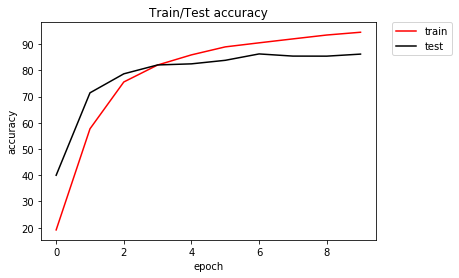

In [51]:
plot_accuracy(train_acc, test_acc)

In [52]:
# Load the trained model
net.load_state_dict(torch.load('linear_idp_model.pkl'))
# Set net in inference mode
net.eval()

coef_idp_VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): func_linear (
    )
    (3): idp_tensor (
    )
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU (inplace)
    (6): func_linear (
    )
    (7): idp_tensor (
    )
    (8): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU (inplace)
    (11): func_linear (
    )
    (12): idp_tensor (
    )
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU (inplace)
    (15): func_linear (
    )
    (16): idp_tensor (
    )
    (17): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (18): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (19): ReLU (inplace)
    (20): func_linear (
    )
    (21): idp_tensor (
    )
    (22): Conv2d(256, 256, kerne

In [53]:
def test_acccuracy(testloader, model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = model(Variable(images, volatile=True).type(dtype))
        labels = Variable(labels, volatile=True).type(torch.cuda.LongTensor)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    acc = 100*correct/total
    print('Accuracy of the network on the 10000 test images: %d %%' % (acc))
    return acc

test_acccuracy(testloader, net)

Accuracy of the network on the 10000 test images: 86 %


86.2

In [54]:
idp_acc_history = []
idp_harmonic_history = [0]*20

idp_scale = list(map(lambda x: x/20,range(1,21)))
print(idp_scale)
for i in idp_scale:
    net_inference = coef_idp_VGG(i,idp_layers).type(dtype)
    net_inference.load_state_dict(torch.load('linear_idp_model.pkl'))
    a = test_acccuracy(testloader, net_inference)
    idp_acc_history.append(a)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 9 %
Accuracy of the network on the 10000 test images: 9 %
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 9 %
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 11 %
Accuracy of the network on the 10000 test images: 13 %
Accuracy of the network on the 10000 test images: 17 %
Accuracy of the network on the 10000 test images: 29 %
Accuracy of the network on the 10000 test images: 53 %
Accuracy of the network on the 10000 test images: 70 %
Accuracy of the network on the 10000 test images: 80 %
Accuracy of the network on the 10000 test images: 83 %
Accuracy of 

In [55]:
idp_acc_history

[10.08,
 9.99,
 9.97,
 10.09,
 9.99,
 10.0,
 10.0,
 10.05,
 11.93,
 13.58,
 17.97,
 29.96,
 53.24,
 70.39,
 80.68,
 83.42,
 85.32,
 85.71,
 86.18,
 86.25]

In [56]:
all_one_acc_history = [10.0,
 10.0,
 10.0,
 10.0,
 10.01,
 10.0,
 10.05,
 9.97,
 9.98,
 10.04,
 10.4,
 10.0,
 10.53,
 15.1,
 20.53,
 24.51,
 33.01,
 46.47,
 69.54,
 84.88]

In [57]:
def plot_idp_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig3 = plt.figure()
    ax1 = fig3.add_subplot(111)
    idp_scale = list(map(lambda x: x/20,range(1,21)))
    idp_scale_i = [i for i in range(0, len(idp_scale))]
    if accuracy1:
        ax1.plot(idp_scale_i, accuracy1, marker='o', linestyle='-', color='r', label="all-one")
    if accuracy2:
        ax1.plot(idp_scale_i, accuracy2, marker='o', linestyle='--', color='g', label="Linear")
    plt.xticks(idp_scale_i, idp_scale)
    plt.xlabel("IDP") 
    plt.ylabel("Accuracy(%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("VGG(CIFAR-10)") 
    plt.savefig('linear_idp_accuracy.png')

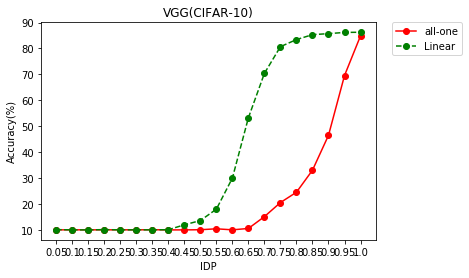

In [58]:
plot_idp_accuracy(all_one_acc_history,idp_acc_history)